In [19]:
import os
import time
import copy
import glob
import cv2
import shutil
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
data_path = 'data/catanddog/train'
    
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

529


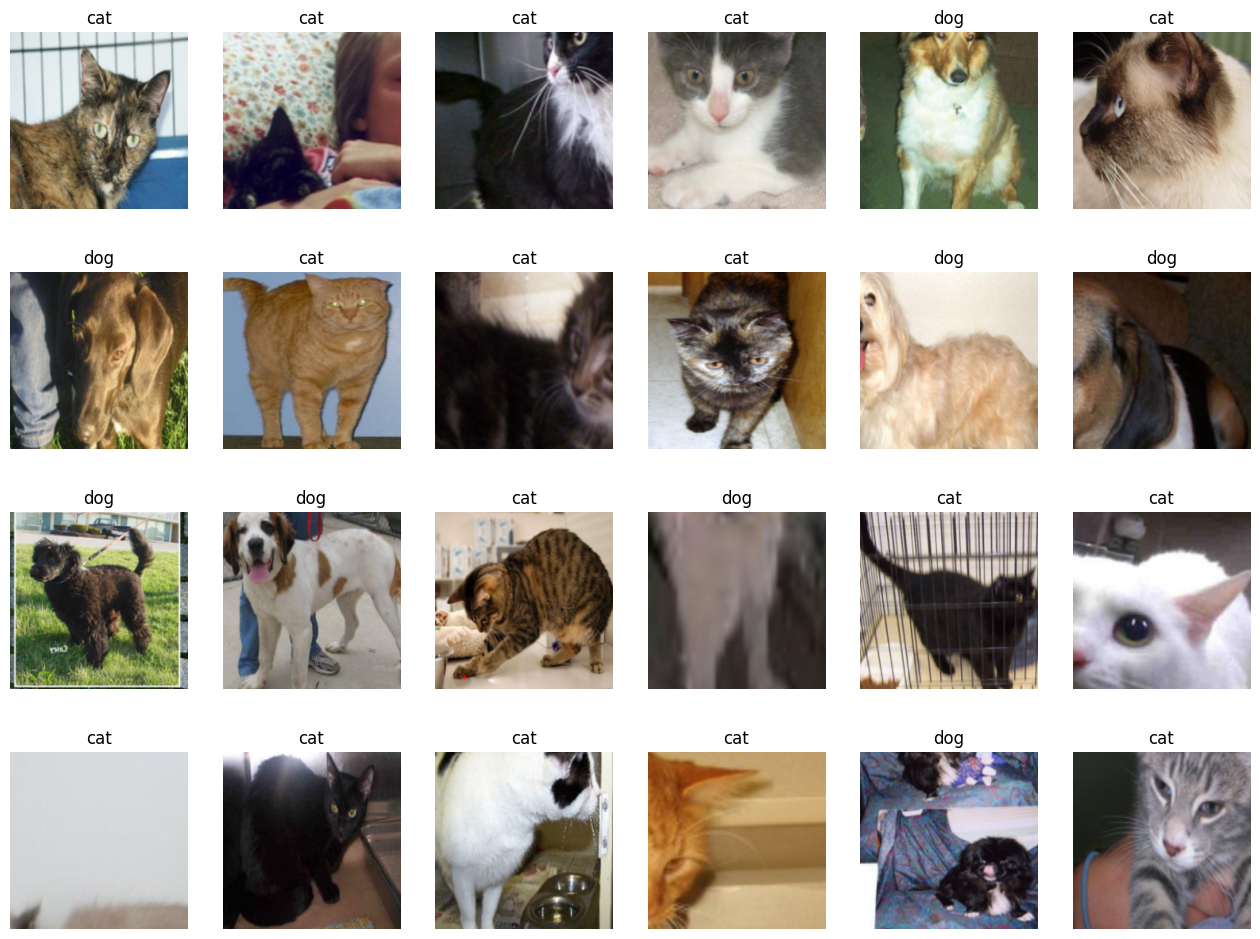

In [22]:
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

### Check requires grad

In [23]:
resnet18 = models.resnet18(pretrained=True)

d:\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)
resnet18.fc = nn.Linear(512,2)

In [25]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0209, -0.0007, -0.0239,  ...,  0.0352,  0.0395,  0.0439],
        [-0.0389, -0.0259, -0.0394,  ...,  0.0440, -0.0350,  0.0241]])
fc.bias tensor([-0.0392,  0.0373])


### Model

In [29]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters()) #fc만 업데이트
criterion = nn.CrossEntropyLoss()

d:\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train = True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [30]:
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5676 Acc: 0.7032

Epoch 1/12
----------
Loss: 0.3338 Acc: 0.8922

Epoch 2/12
----------
Loss: 0.2592 Acc: 0.9093

Epoch 3/12
----------
Loss: 0.2042 Acc: 0.9338

Epoch 4/12
----------
Loss: 0.2084 Acc: 0.9168

Epoch 5/12
----------
Loss: 0.1995 Acc: 0.9225

Epoch 6/12
----------
Loss: 0.1840 Acc: 0.9301

Epoch 7/12
----------
Loss: 0.1975 Acc: 0.9112

Epoch 8/12
----------
Loss: 0.1394 Acc: 0.9603

Epoch 9/12
----------
Loss: 0.1862 Acc: 0.9168

Epoch 10/12
----------
Loss: 0.2152 Acc: 0.9112

Epoch 11/12
----------
Loss: 0.1843 Acc: 0.9244

Epoch 12/12
----------
Loss: 0.1380 Acc: 0.9452

Training complete in 1m 31s
Best Acc: 0.960302


In [31]:
test_path = 'data/catanddog/test'

transform = transforms.Compose(         # test data에서는 random crop을 안해줌
                [
                    transforms.Resize(224),     
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

107


In [32]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [34]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['data/catanddog\\00.pth', 'data/catanddog\\01.pth', 'data/catanddog\\02.pth', 'data/catanddog\\03.pth', 'data/catanddog\\04.pth', 'data/catanddog\\05.pth', 'data/catanddog\\06.pth', 'data/catanddog\\07.pth', 'data/catanddog\\08.pth', 'data/catanddog\\09.pth', 'data/catanddog\\10.pth', 'data/catanddog\\11.pth', 'data/catanddog\\12.pth']
Loading model data/catanddog\00.pth
Acc: 0.9159

Loading model data/catanddog\01.pth
Acc: 0.9252

Loading model data/catanddog\02.pth
Acc: 0.9439

Loading model data/catanddog\03.pth
Acc: 0.9439

Loading model data/catanddog\04.pth
Acc: 0.9533

Loading model data/catanddog\05.pth
Acc: 0.9439

Loading model data/catanddog\06.pth
Acc: 0.9346

Loading model data/catanddog\07.pth
Acc: 0.9533

Loading model data/catanddog\08.pth
Acc: 0.9346

Loading model data/catanddog\09.pth
Acc: 0.9533

Loading model data/catanddog\10.pth
Acc: 0.9439

Loading model data/catanddog\11.pth
Acc: 0.9346

Loading model data/catanddog\12.pth
Acc: 0.9533

Validation c

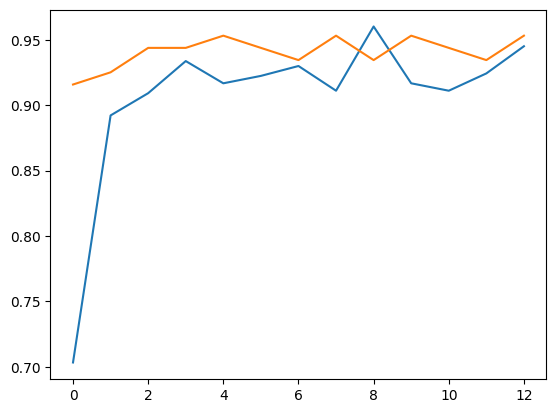

In [35]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

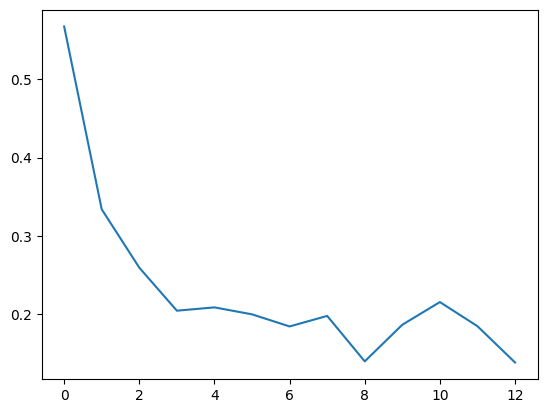

In [36]:
plt.plot(train_loss_hist)
plt.show()

In [42]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

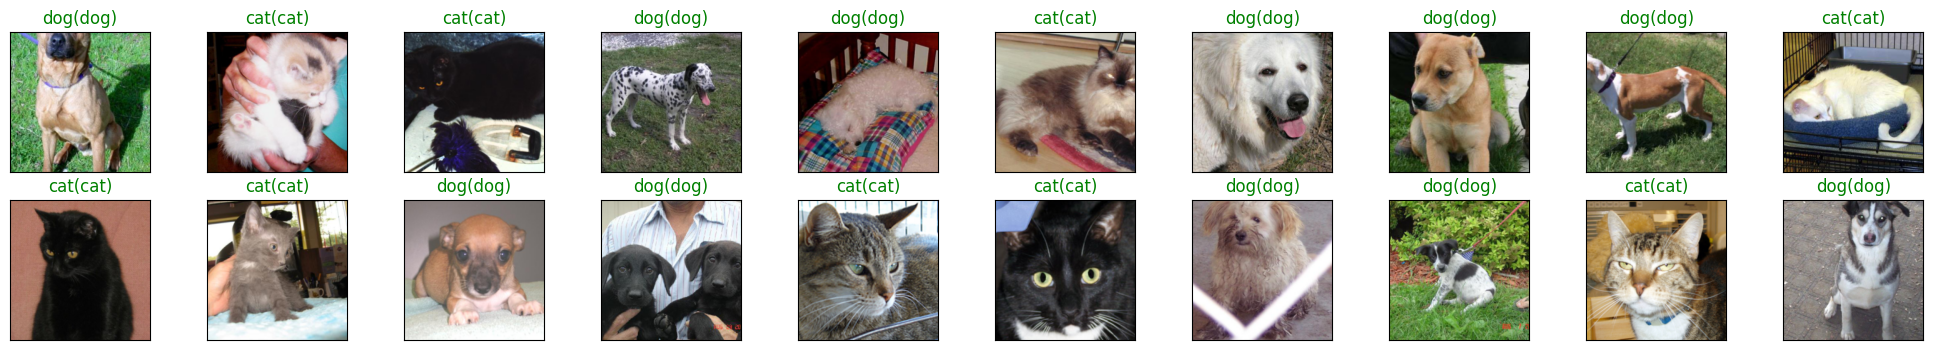

<Figure size 640x480 with 0 Axes>

In [45]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=next(dataiter)
model.to('cpu')
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)